# Text Adventure

We've established that the model can handle reasoning about basic shit, like "there is a wall I cannot go there I need to go in a direction which is walkable, and then walking in that general direction"

But we want to convert this enviroment into something that requires a more baseline human like intelligence, so we are going to create some obstacle, and some resources which are required to navigate through the environment, lets call this an "adventure".

Lets break the notebook up into 5 parts.

1. Generating some mazes
2. Adding some "puzzle mechanics"

## Generating some mazes

Lets start with a grid of nodes

```
A B E I Q
C D F J T
G H K O U
L M N P W
R S V X Y
```

Now lets visualize this as a graph

```
A <-> (B, C)
B <-> (A, E, D)
...
```

a maze is just something where the path exists between the start and the stop

In [72]:
import matplotlib.pyplot as plt
import random

In [157]:
Edge = tuple
GraphId = int

def edge(A: GraphId, B: GraphId) -> Edge: 
    return Edge(sorted([A, B]))

class GraphGen:
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.N = (width * height) - 1

    def _cart_to_id(self, x: int, y: int) -> GraphId:
        if not (0 <= x < self.width and 0 <= y < self.height):
            return -1  # Invalid coordinates
        return y * self.width + x
    
    def _id_to_cart(self, _id: GraphId) -> tuple[int, int]:
        y = _id // self.width
        x = _id % self.width
        return (x, y)
    
    def _valid_id(self, _id: int) -> bool:
        if not (0 <= _id <= self.N):
            return False
        x, y = self._id_to_cart(_id)
        return 0 <= x < self.width and 0 <= y < self.height
        
    def _all_edges(self, x: int, y: int) -> list[Edge[GraphId, GraphId]]:
        deltas = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        ans = []
        graph_id = self._cart_to_id(x, y)
        
        for (dx, dy) in deltas:
            sink = self._cart_to_id(x+dx, y+dy)
            
            if self._valid_id(sink):
                ans.append(edge(graph_id, sink))
                
        return ans
        
    def _complete_manhattan_graph(self) -> set[Edge[GraphId, GraphId]]:
        edges = set() # handle directional w. set dedupe
    
        for x in range(self.width):
            for y in range(self.height):
                graph_id = self._cart_to_id(x, y)
                adj = self._all_edges(x, y)
                for a in adj:
                    edges.add(a)
    
        return edges

    def _path_helper(self, edge_constraint: Edge[GraphId, GraphId]) -> list[Edge[GraphId, GraphId]]:
        start, end = edge_constraint
        queue = [(start, [start])]  # (current_node, path_so_far)
        visited = {start}
    
        while queue:
            current, path = queue.pop(0)
            
            if current == end:
                edges = []
                for i in range(len(path)-1):
                    edges.append(edge(path[i], path[i+1]))
                return edges
    
            x, y = self._id_to_cart(current)
            
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                new_x, new_y = x + dx, y + dy
                new_id = self._cart_to_id(new_x, new_y)
                
                if (self._valid_id(new_id) and new_id not in visited):
                    visited.add(new_id)
                    queue.append((new_id, path + [new_id]))
        
        return []  # Return empty list if no path found

    def _wonky_path_helper(self, edge_constraint: Edge[GraphId, GraphId]) -> list[Edge[GraphId, GraphId]]:
        # modify bfs to make it deliberately windy and all over the place
        # start by simply randomizing directions
        start, end = edge_constraint
        queue = [(start, [start])]  # (current_node, path_so_far)
        visited = {start}
    
        while queue:
            current, path = queue.pop(0)
            
            if current == end:
                edges = []
                for i in range(len(path)-1):
                    edges.append(edge(path[i], path[i+1]))
                return edges
    
            x, y = self._id_to_cart(current)

            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            random.shuffle(directions)
            
            for dx, dy in directions:
                new_x, new_y = x + dx, y + dy
                new_id = self._cart_to_id(new_x, new_y)
                
                if (self._valid_id(new_id) and new_id not in visited):
                    visited.add(new_id)
                    queue.append((new_id, path + [new_id]))
        
        return []  # Return empty list if no path found

    def constrained_maze(self, constraint: list[Edge[GraphId, GraphId]], wonky: bool = True) -> set[Edge[GraphId, GraphId]]:
        adj_mat = set()
        def _compute_constraint(c):
            if wonky:
                path = self._wonky_path_helper(c)
            else:
                path = self._path_helper(c)
            for edge in path:
                adj_mat.add(edge)
        
        list(map(_compute_constraint, constraint)) # cast to list -> evaluate
        
        return adj_mat

    def _plot_wall(self, s1: GraphId, s2: GraphId):
        # pulled this nice maze plotting function from norvig's fantastic blog
        # https://github.com/norvig/pytudes/blob/main/ipynb/Maze.ipynb
        (x1, y1), (x2, y2) = self._id_to_cart(s1), self._id_to_cart(s2)
        
        if x1 == x2: # horizontal wall
            y = max(y1, y2)
            X, Y = [x1, x1+1], [y, y]
        else: # vertical wall
            x = max(x1, x2)
            X, Y = [x, x], [y1, y1+1]
        plt.plot(X, Y, 'k-', linewidth=1)

    def plt_adj_mat(self, adj_mat: Edge[GraphId, GraphId], with_ids: bool = False):
        plt.figure(figsize=(self.width/2, self.height/2))
        plt.axis('off')
        plt.gca().invert_yaxis()
        
        for x in range(self.width):
            for y in range(self.height):
                graph_id = self._cart_to_id(x, y)
                adjs = self._all_edges(x, y)

                if with_ids:
                    plt.text(x + 0.5, y + 0.5, str(graph_id), 
                        horizontalalignment='center',
                        verticalalignment='center')

                for adj in adjs:
                    # draw a wall if path don't exist
                    if adj not in adj_mat:
                        self._plot_wall(adj[0], adj[1])

        # Draw boundary walls
        plt.plot([0, self.width], [0, 0], 'k-', linewidth=1)                     # top
        plt.plot([0, self.width], [self.height, self.height], 'k-', linewidth=1) # bottom
        plt.plot([0, 0], [0, self.height], 'k-', linewidth=1)                    # left
        plt.plot([self.width, self.width], [0, self.height], 'k-', linewidth=1)  # right

Kinda cool but I want to be able to place some constraints on the maze. Eg I want to be able to guarantee that a path exists between 2 ids within the graph. I guess lets just start by find a path between two of the IDs, then constructing an adj mat from that

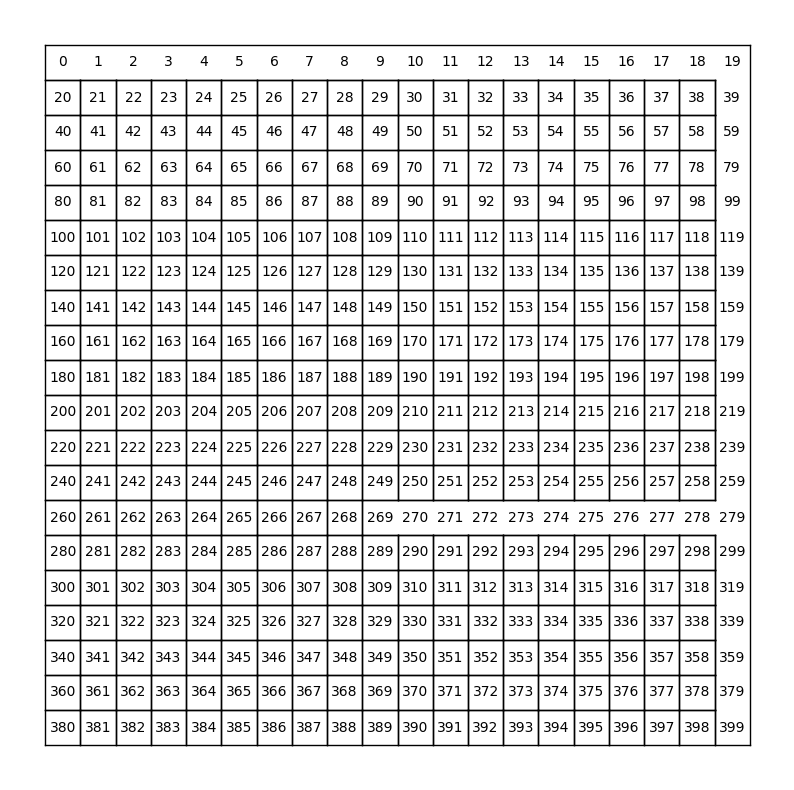

In [158]:
graph_generator = GraphGen(20, 20)
adj_mat = graph_generator.constrained_maze([[0, 399], [269, 399]], wonky=False)
graph_generator.plt_adj_mat(adj_mat, with_ids=True)

that is kind cool but the paths right now are super... boring and straight, we should use a strategy which will get there but maybe be take a few random turns

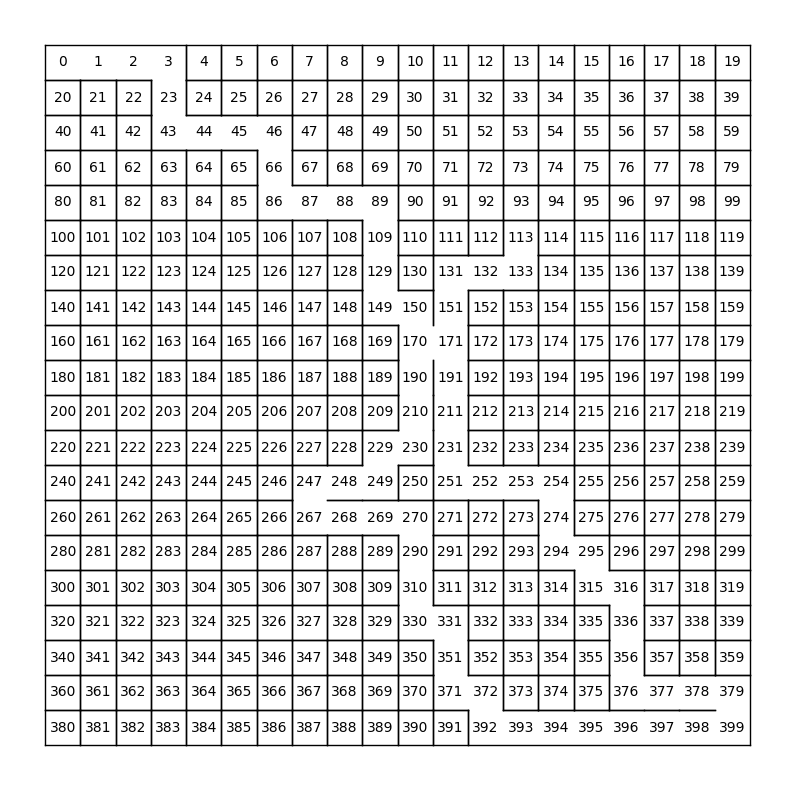

In [162]:
graph_generator = GraphGen(20, 20)
adj_mat = graph_generator.constrained_maze([[0, 399], [269, 399], [113, 247], [247, 269]], wonky=True)
graph_generator.plt_adj_mat(adj_mat, with_ids=True)

dope! next section

## Adding some "puzzle mechanics"

A "puzzle mechanic" is the concept that there is something the player needs to "figure out" before they can procede. So we are going to have "locked walls" and "keys".

Such that when a player reaches a "locked wall", they know that they need to go back and collect a "key" on another already accessible tile. Then once they visit the "key" tile, they will the "locked wall" will disappear, createing an adjacency.

pseudo code
```
generate a complete map
    pick some random point, between (start, end) and add a "locked wall"
    pick some point between (start, locked_wall) and add a "key"
```

Considerations:
* There have to be multiple paths between (start, locked wall), otherwise the player is virtually guaranteed to acquire the key before finding the locked wall
* If there are multiple paths between (start and end), there are 2 things we can do
    * create a bottleneck where the key is required at the bottleneck
    * create multiple bottlenecks, there the key is required at each bottleneck
    * create multiple bottlenecks, where a different key is required for each